***Title: Transient response of Giovanna's device at a drive power of -34dBm***  
***Date: 21/03/17***

In [1]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import csv
import os
cwd = os.getcwd()
%matplotlib inline
pylab.rcParams['figure.figsize'] = (12, 8)


def mean_photons_calc(probabilities):
    photons = np.zeros(probabilities.shape[1])
    for i in range(photons.shape[0]):
        for j in range(probabilities.shape[0]):
            photons[i] = photons[i] + j * probabilities[j, i]
    return photons


def times_qload(folder_path):
    times_path = folder_path + '/times'
    times = qload(times_path)
    times = times / (2 * np.pi * 1000)
    return times


class Parameters:
    def __init__(self, wc, wq, eps, g, chi, kappa, gamma, t_levels, c_levels):
        self.wc = wc
        self.wq = wq
        self.eps = eps
        self.g = g
        self.chi = chi
        self.gamma = gamma
        self.kappa = kappa
        self.t_levels = t_levels
        self.c_levels = c_levels

    def copy(self):
        params = Parameters(self.wc, self.wq, self.eps, self.g, self.chi, self.kappa, self.gamma, self.t_levels, self.c_levels)
        return params


class Results:
    def __init__(self, params=np.array([]), wd_points=np.array([]),
                 transmissions=np.array([]), edge_occupations_c=np.array([]), edge_occupations_t=np.array([])):
        self.params = params
        self.wd_points = wd_points
        self.transmissions = transmissions
        self.edge_occupations_c = edge_occupations_c
        self.edge_occupations_t = edge_occupations_t
        self.abs_transmissions = np.absolute(self.transmissions)
        self.size = self.wd_points.size

    def concatenate(self, results):
        combined_params = np.concatenate([self.params, results.params])
        combined_wd_points = np.concatenate([self.wd_points, results.wd_points])
        combined_transmissions = np.concatenate([self.transmissions, results.transmissions])
        combined_edge_occupations_c = np.concatenate([self.edge_occupations_c, results.edge_occupations_c])
        combined_edge_occupations_t = np.concatenate([self.edge_occupations_t, results.edge_occupations_t])
        sort_indices = np.argsort(combined_wd_points)
        combined_params = combined_params[sort_indices]
        combined_wd_points = combined_wd_points[sort_indices]
        combined_transmissions = combined_transmissions[sort_indices]
        combined_edge_occupations_c = combined_edge_occupations_c[sort_indices]
        combined_edge_occupations_t = combined_edge_occupations_t[sort_indices]
        combined_results = Results(combined_params, combined_wd_points,
                                   combined_transmissions, combined_edge_occupations_c, combined_edge_occupations_t)
        return combined_results

    def delete(self, indices):
        reduced_params = np.delete(self.params, indices)
        reduced_wd_points = np.delete(self.wd_points, indices)
        reduced_transmissions = np.delete(self.transmissions, indices)
        reduced_edge_occupations_c = np.delete(self.edge_occupations_c, indices)
        reduced_edge_occupations_t = np.delete(self.edge_occupations_t, indices)
        reduced_results = Results(reduced_params, reduced_wd_points,
                                  reduced_transmissions, reduced_edge_occupations_c, reduced_edge_occupations_t)
        params_change = (reduced_params == self.params)
        wd_points_change = (reduced_wd_points == self.wd_points)
        transmissions_change = (reduced_transmissions == self.transmissions)
        edge_occupations_c_change = (reduced_edge_occupations_c == self.edge_occupations_c)
        edge_occupations_t_change = (reduced_edge_occupations_t == self.edge_occupations_t)
        print np.all([params_change, wd_points_change, transmissions_change, edge_occupations_c_change, edge_occupations_t_change])
        return reduced_results

    def queue(self):
        queue = Queue(self.params, self.wd_points)
        return queue

In [2]:
def data_load(file_path):
    n_row = 0
    with open(file_path , 'rb') as csvfile:
        reader = csv.reader(csvfile, delimiter='\t')
        for row in reader:
            if n_row == 0:
                powers = np.array([float(value) for value in row])
            elif n_row == 1:
                frequencies = np.array([float(value) for value in row])
                data = np.zeros([len(powers), len(frequencies)])
            else:
                data[n_row - 2, :] = [float(value) for value in row]
            n_row += 1
    return powers, frequencies, data

powers, frequencies, data = data_load('./third_cool_down/CavC_RfSweep_pRF.txt')
frequencies = frequencies / 1000000000
frequencies = frequencies + 0.0626

indices = np.argsort(powers)[::-1]
powers = powers[indices]
data = data[indices,:]

max_indices = np.argmax(data, axis=1)
frequencies_g = frequencies[max_indices]
amplitudes_g = np.array([data[i, max_indices[i]] for i  in range(data.shape[0])])

Loaded dict object.


/usr/lib64/python2.7/site-packages/matplotlib/collections.py:526: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


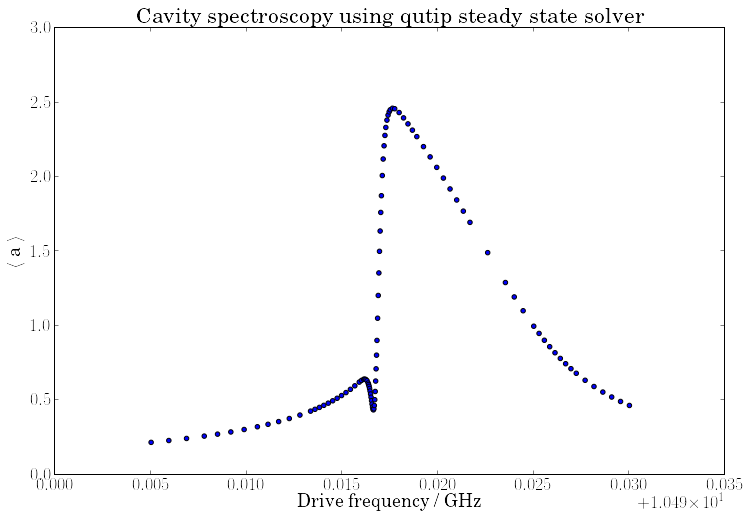

In [3]:
spectroscopy_path = cwd + '/readout_spectroscopy/spectroscopy'
multi_results = qload(spectroscopy_path)
results = multi_results[0.004]
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'size'   : 18}
plt.rc('font', **font)
pylab.rcParams['figure.figsize'] = (12, 8)
plt.scatter(results.wd_points, results.abs_transmissions)
plt.title('Cavity spectroscopy using qutip steady state solver')
plt.xlabel('Drive frequency / GHz')
plt.ylabel(r'$\langle$ a $\rangle$')

The graph above shows the results of a qutip simulation of spectroscopy of Giovanna's current device with a drive amplitude of $\epsilon$ = 4 MHz. The peak is at 10.5076 GHz. I'm interested in simulating the transient response of the cavity with different initial transmon states and I'm particularly interested in drive frequencies around the dip since this indicates the presence of bistability.  

For reference the parameters of the system can be seen below.

In [29]:
params = qload(cwd + '/readout_steady_state/2017-03-08--18-03-03/params')
print "Transmon levels = " + str(params.t_levels)
print "Cavity levels = " + str(params.c_levels)
print "Bare cavity resonance f_c = " + str(params.wc) + " GHz"
print "First transmon transition f_01 = " + str(params.wq) + " GHz"
print "Cavity decay rate \kappa = " + str(params.kappa) + " GHz"
print "Transmon relaxation rate \gamma = " + str(params.gamma) + " GHz"
print "Perturbed coupling g = " + str(params.g) + " GHz (measured)"
print "Unperturbed coupling g = 0.275 GHz (used in model)"
print "Transmon non-linearity = " + str(params.chi) + " GHz"
print "Drive \epsilon = " + str(params.eps) + " GHz"

Loaded instance object.
Transmon levels = 5
Cavity levels = 20
Bare cavity resonance f_c = 10.4267 GHz
First transmon transition f_01 = 9.39128 GHz
Cavity decay rate \kappa = 0.00147 GHz
Transmon relaxation rate \gamma = 0.000833 GHz
Perturbed coupling g = 0.3096 GHz (measured)
Unperturbed coupling g = 0.275 GHz (used in model)
Transmon non-linearity = -0.097 GHz
Drive \epsilon = 0.004 GHz


Loaded dict object.


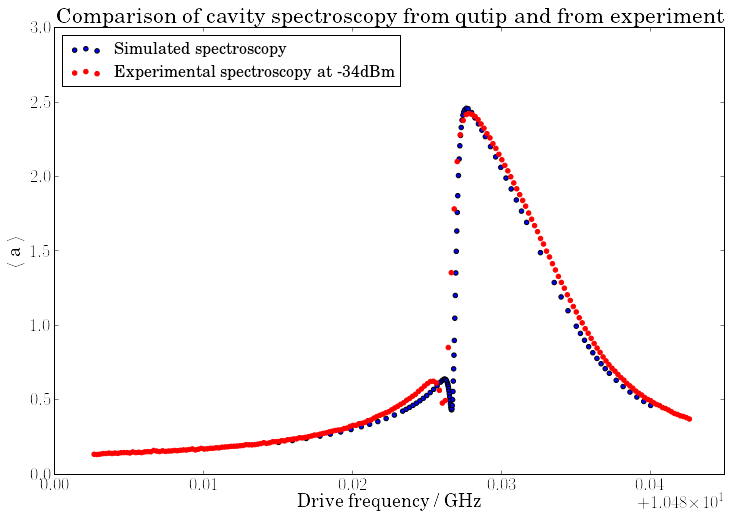

In [4]:
spectroscopy_path = cwd + '/readout_spectroscopy/spectroscopy'
multi_results = qload(spectroscopy_path)
results = multi_results[0.004]
plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'size'   : 18}
plt.rc('font', **font)
pylab.rcParams['figure.figsize'] = (12, 8)
plt.scatter(results.wd_points, results.abs_transmissions)
plt.scatter(frequencies, 350 * data[2, :], color='r')
plt.title('Comparison of cavity spectroscopy from qutip and from experiment')
plt.xlabel('Drive frequency / GHz')
plt.ylabel(r'$\langle$ a $\rangle$')
plt.legend(['Simulated spectroscopy', 'Experimental spectroscopy at -34dBm'], loc=2, fontsize=16)

Overlaying the experimental results from cavity spectroscopy at -34dBm shows fairly close agreement between the simulation and the Giovanna's results.

Loaded dict object.
Loaded dict object.
Loaded dict object.
Loaded dict object.
Loaded ndarray object.


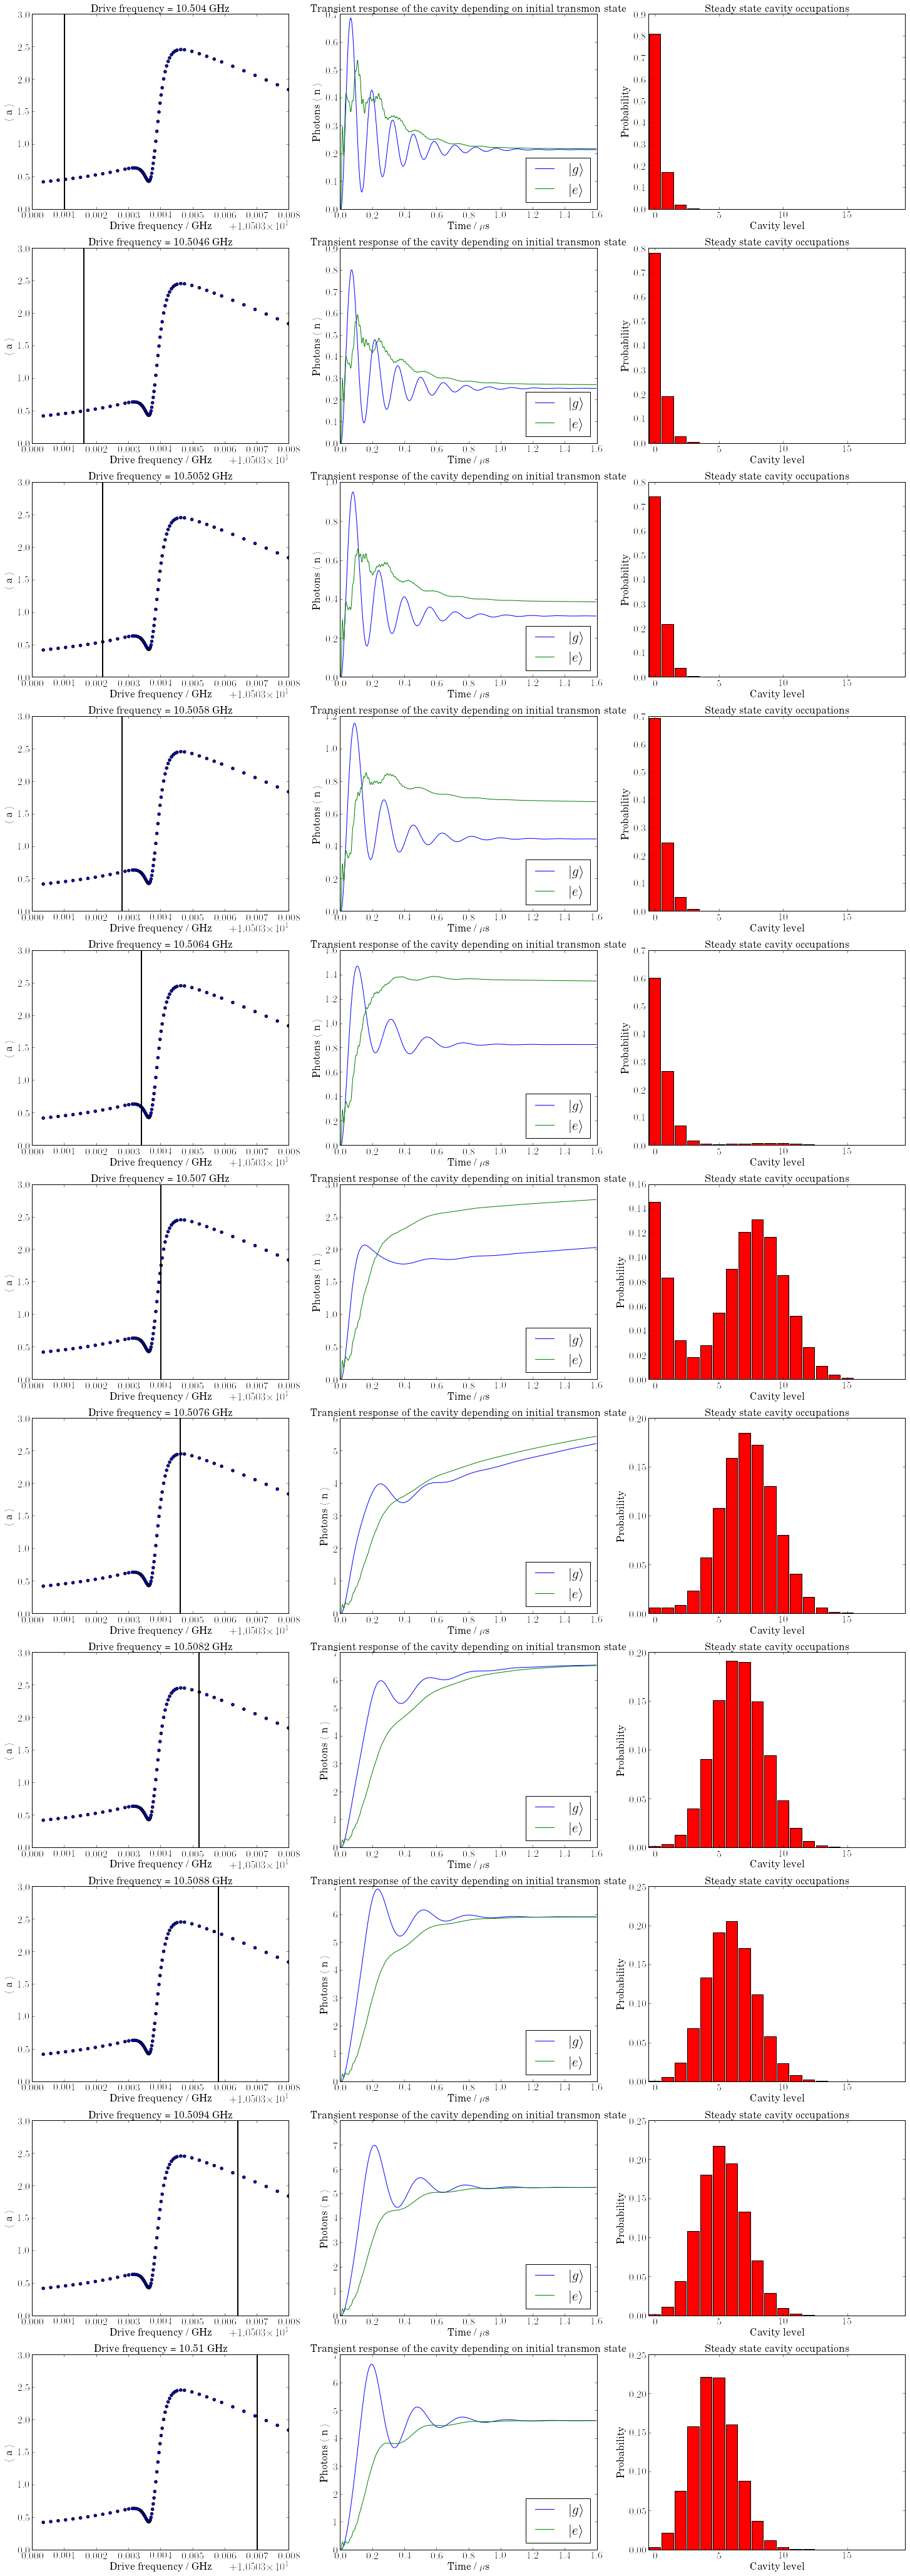

In [132]:
master_down_path = cwd + '/master/3/master_readout_down/2017-03-08--17-36-21'
multi_results_down = qload(master_down_path + '/expectations')
master_up_path = cwd + '/master/3/master_readout_up/2017-03-08--17-35-42'
multi_results_up = qload(master_up_path + '/expectations')
rho_ss_dict = qload(cwd + '/readout_steady_state/2017-03-08--18-03-03/density_matrix')

spectroscopy_path = cwd + '/readout_spectroscopy/spectroscopy'
multi_results_spec = qload(spectroscopy_path)
spec_results = multi_results_spec[0.004]

times = times_qload(master_down_path)
keys = sorted(multi_results_down.keys())
number_of_drives = len(multi_results_down)
fontsize = 17
width = 0.9
fontsize = 16
rows = number_of_drives
columns = 3
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font = {'family' : 'normal',
        'size'   : 18}
plt.rc('font', **font)
pylab.rcParams['figure.figsize'] = (25, 20 * number_of_drives)
for idx, key in enumerate(keys):
    plt.subplot(columns*rows, columns, 1 + columns*idx)
    plt.scatter(spec_results.wd_points, spec_results.abs_transmissions)
    plt.title('Drive frequency = ' + str(key) + ' GHz', fontsize=fontsize)
    plt.xlabel('Drive frequency / GHz', fontsize=fontsize)
    plt.ylabel(r'$\langle$ a $\rangle$', fontsize=fontsize)
    plt.xlim([10.503, 10.511])
    plt.axvline(x=key, ymin=0.0, ymax = 3.0, linewidth=2, color='k')
    plt.tick_params(axis='both', labelsize=fontsize)
    
    plt.subplot(rows*columns, columns, columns*idx + 2)
    mean_photons_down = mean_photons_calc(np.array(multi_results_down[key]))
    mean_photons_up = mean_photons_calc(np.array(multi_results_up[key]))
    plt.plot(times, mean_photons_down)
    plt.plot(times, mean_photons_up)
    legend = [r'$| g \rangle$', r'$| e \rangle$']
    plt.legend(legend, loc=4)
    plt.xlabel(r'Time / $\mu$s', fontsize=fontsize)
    plt.ylabel(r'Photons $\langle$ n $\rangle$', fontsize=fontsize)
    plt.tick_params(axis='both', labelsize=fontsize)
    plt.title('Transient response of the cavity depending on initial transmon state', fontsize=fontsize)
    
    plt.subplot(rows*columns, columns, 3 + columns*idx)
    rho_ss = rho_ss_dict[key]
    rho_c_ss = rho_ss.ptrace(0)
    cavity_occupations_qutip = rho_c_ss.diag()
    ind = np.arange(cavity_occupations_qutip.size)
    plt.bar(ind - width / 2, cavity_occupations_qutip, width, color='r')
    plt.xlim([-0.5, cavity_occupations_qutip.size - 0.5])
    plt.title('Steady state cavity occupations', fontsize=fontsize)
    plt.xlabel('Cavity level', fontsize=fontsize)
    plt.ylabel('Probability', fontsize=fontsize)
    plt.tick_params(axis='both', labelsize=fontsize)

The grid of graphs above show the results of a drive frequency sweep through the dip. Each row corresponds to a different drive frequency which can be seen in the left hand column. The central colummn shows the transient response of the cavity as calculated using the qutip master equation solver. The left hand colum shows a histogram of cavity level occupations which you would expect in the steady state.  

The first thing to notice about the transient responses is that either side of the dip the two responses quickly converge to the steady state over a period of about 1 $\mu$s which is close to the timescales set by the cavity and transmon relaxation times which are 0.7 $\mu$s and 1.2 $\mu$s respectively. However, close to the dip, where we have bistabilility, the two transient responses do not converge with each other even over the full 1.6 $\mu$s which I have simulated. As seen in the previous notebook these states can take many 10s of microseconds to reach steady state and converge with eachother.

If you look further down the page you will see results from a finer sweep more closely focused on the region of bistability.

Loaded dict object.
Loaded dict object.
Loaded dict object.
Loaded dict object.
Loaded ndarray object.


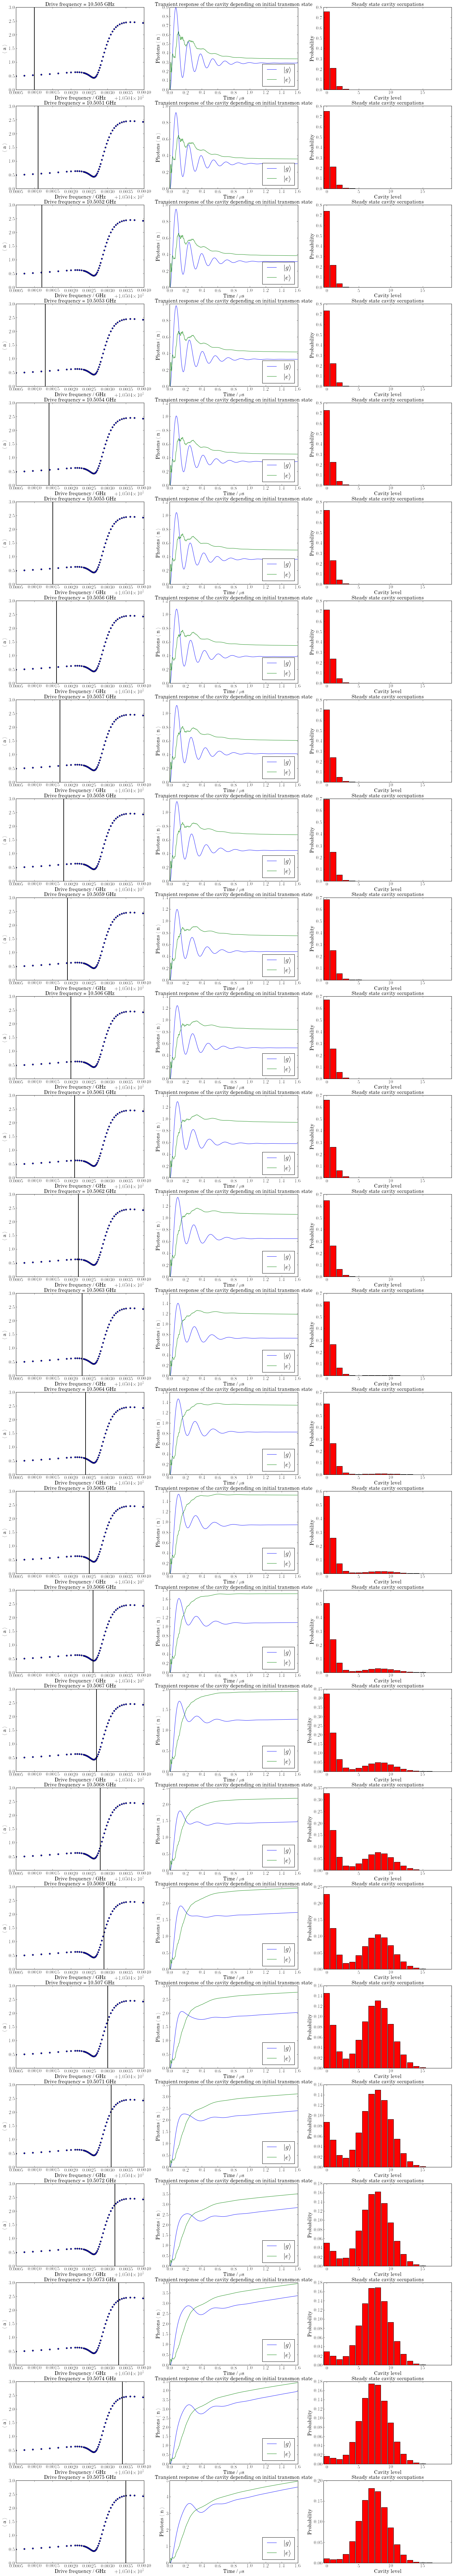

In [133]:
master_down_path = cwd + '/master/4/master_readout_4MHz_down/2017-03-09--18-11-24'
multi_results_down = qload(master_down_path + '/expectations')
master_up_path = cwd + '/master/4/master_readout_4MHz_up/2017-03-09--18-07-30'
multi_results_up = qload(master_up_path + '/expectations')
rho_ss_dict = qload(cwd + '/readout_steady_state/2017-03-09--16-57-20/density_matrix')

spectroscopy_path = cwd + '/readout_spectroscopy/spectroscopy'
multi_results_spec = qload(spectroscopy_path)
spec_results = multi_results_spec[0.004]

times = times_qload(master_down_path)
keys = sorted(multi_results_down.keys())
number_of_drives = len(multi_results_down)
fontsize = 17
width = 0.9
fontsize = 16
rows = number_of_drives
columns = 3
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font = {'family' : 'normal',
        'size'   : 18}
plt.rc('font', **font)
pylab.rcParams['figure.figsize'] = (25, 17 * number_of_drives)
for idx, key in enumerate(keys):
    plt.subplot(columns*rows, columns, 1 + columns*idx)
    plt.scatter(spec_results.wd_points, spec_results.abs_transmissions)
    plt.title('Drive frequency = ' + str(key) + ' GHz', fontsize=fontsize)
    plt.xlabel('Drive frequency / GHz', fontsize=fontsize)
    plt.ylabel(r'$\langle$ a $\rangle$', fontsize=fontsize)
    plt.xlim([10.5045, 10.508])
    plt.axvline(x=key, ymin=0.0, ymax = 3.0, linewidth=2, color='k')
    plt.tick_params(axis='both', labelsize=fontsize)
    
    plt.subplot(rows*columns, columns, columns*idx + 2)
    mean_photons_down = mean_photons_calc(np.array(multi_results_down[key]))
    mean_photons_up = mean_photons_calc(np.array(multi_results_up[key]))
    plt.plot(times, mean_photons_down)
    plt.plot(times, mean_photons_up)
    legend = [r'$| g \rangle$', r'$| e \rangle$']
    plt.legend(legend, loc=4)
    plt.xlabel(r'Time / $\mu$s', fontsize=fontsize)
    plt.ylabel(r'Photons $\langle$ n $\rangle$', fontsize=fontsize)
    plt.tick_params(axis='both', labelsize=fontsize)
    plt.title('Transient response of the cavity depending on initial transmon state', fontsize=fontsize)
    
    plt.subplot(rows*columns, columns, 3 + columns*idx)
    rho_ss = rho_ss_dict[key]
    rho_c_ss = rho_ss.ptrace(0)
    cavity_occupations_qutip = rho_c_ss.diag()
    ind = np.arange(cavity_occupations_qutip.size)
    plt.bar(ind - width / 2, cavity_occupations_qutip, width, color='r')
    plt.xlim([-0.5, cavity_occupations_qutip.size - 0.5])
    plt.title('Steady state cavity occupations', fontsize=fontsize)
    plt.xlabel('Cavity level', fontsize=fontsize)
    plt.ylabel('Probability', fontsize=fontsize)
    plt.tick_params(axis='both', labelsize=fontsize)

This second grid of graphs is similar to the first except that it covers a narrower sweep which focuses more on the region around the dip and peak.